In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [98]:
df = pd.read_csv('test_restaurant.csv')

In [99]:
df.head()

,date,num_visitors
0,2000-01-01,49.128490
1,2000-01-02,50.288060
2,2000-01-03,53.549213
3,2000-01-04,45.453240
4,2000-01-05,49.469402


In [100]:
#Check for missing values
df.isnull().sum()

date            0
num_visitors    0
dtype: int64

In [101]:
#Find number of rows and columns in the dataframe
df.shape

(3651, 2)

In [102]:
#Check for duplicate values
df.duplicated().sum()

0

In [103]:
# Check if same date has been repeated twice
df.date.duplicated().sum()

0

In [104]:
#Change date column to datetime and setting the date as index
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace = True)


In [114]:
df.index.min(),df.index.max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2009-12-29 00:00:00'))

In [105]:
# Summary statistics for the data frame

df.describe()

,num_visitors
count,3651.000000
mean,24.782759
std,11.188746
min,-7.867497
25%,17.042217
50%,22.950304
75%,29.260646
max,69.849130


As we can see from the summary above, the minimum number for the visitor is -7.96 which is not usual. So we are going to check those cases.

In [66]:
df[df['num_visitors'] < 0]

,num_visitors
date,
2000-02-06,-1.293132
2001-02-05,-7.867497


In [67]:
# Here it is best to remove these entries as number of visitors can never be negative or this may be a typo.
df = df[df['num_visitors'] >= 0]

In [68]:
df.describe()

,num_visitors
count,3649.000000
mean,24.798853
std,11.170399
min,0.181759
25%,17.052917
50%,22.961277
75%,29.262848
max,69.849130


In [106]:
rolmean = df.rolling(window = 365).mean()
rolstd = df.rolling(window = 365).std()


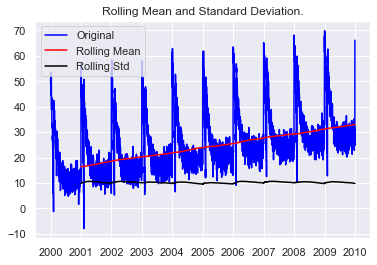

In [107]:
#Plotting the time series

orig = plt.plot(df,color = 'blue',label = 'Original')
mean = plt.plot(rolmean,color = 'red',label = 'Rolling Mean')
std = plt.plot(rolstd,color = 'black',label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Standard Deviation.')
plt.show(block = False)


From the above graph, we are able to see that rolling mean has a slight positive trend and the data is also nearly stationary.

## Seasonality trend and residuals by using ETS decomposition

<Figure size 432x288 with 0 Axes>

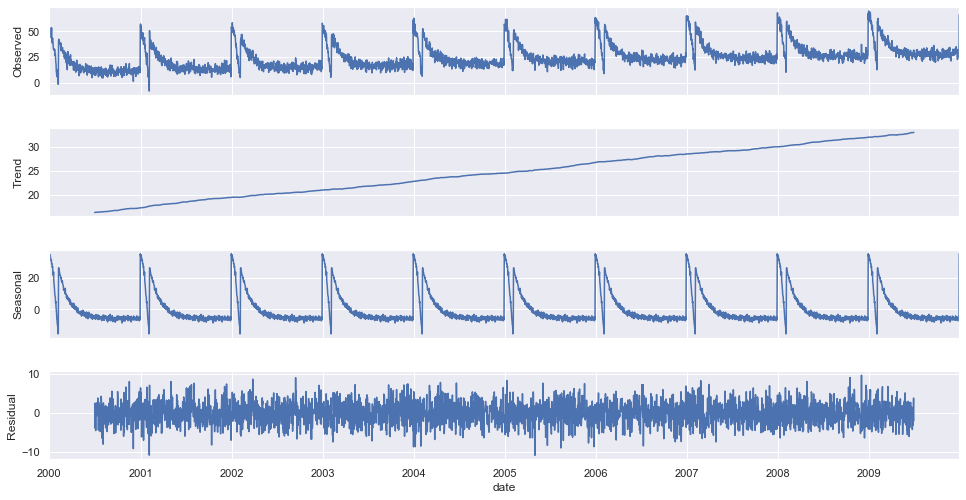

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, freq=365)  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(15, 8)

## ACDF Test

The data is indeed seasonal and follows an upward trend. 
Now we will check whether the data is stationary or not. For this, we will perform a test called the Dickey-Fuller test. In the field of statistics, the Dickey-Fuller test (ADF) is used to test the null hypothesis (which is the Data is not stationary)

In [109]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(df['num_visitors'])
print ('ADF Test:')
labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

for value,label in zip(test_result,labels):
    print (label+': '+str(value))
if test_result[1] <= 0.05:
    print ("Reject null hypothesis and data is stationary")
else:
    print ("Fail to reject H0 thereby data is non-stationary ")

ADF Test:
ADF Statistic: -4.322697080560924
p-value: 0.00040568352886978043
No. of Lags Used: 30
Number of Observations Used: 3620
Reject null hypothesis and data is stationary


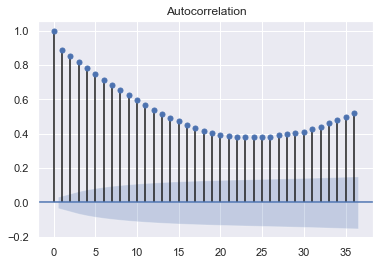

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
fig_first = plot_acf(df["num_visitors"].shift(30).dropna())

From the Dicky Fuller Test, it is suggested that we can consider the data as stationary.

## Using ARMA model for prediction

In [118]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(df, order=(1,0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARMA(df, order=(2,0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARMA(df, order=(1,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

C:\Users\shres\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The AIC for an AR(1) is:  22350.43233623328


C:\Users\shres\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The AIC for an AR(2) is:  22016.57822034227


C:\Users\shres\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The AIC for an ARMA(1,1) is:  21965.782148543803


ARMA(1,1) has the lowest AIC value among the others.

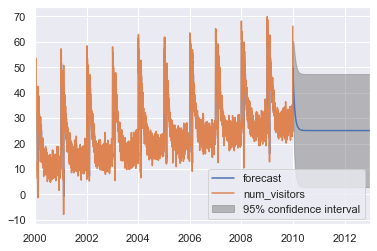

In [121]:
res_arma11.plot_predict(start='2000-01-01', end='2012-12-29')
plt.show()